In [7]:
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Uyarıları kapat
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler yüklendi ve hazır.")

Kütüphaneler yüklendi ve hazır.


In [9]:
# Veriyi Yükle (Ultra Optimized Dataset)
df = pd.read_csv('hackathon_ultra_optimized.csv', low_memory=False)

# Kritik Özellikler Ekle
# Mahalle Değeri * Ev Büyüklüğü (Pahalı semtteki büyük evleri belirginleştirir)
df['Interaction_Score'] = df['m² (Gross)'] * df['Neighborhood_TargetEncoded']

# Ferahlık Endeksi (Net alan / Oda sayısı)
df['Spaciousness'] = df['m² (Net)'] / df['Total_Rooms']

# Price_per_sqm kolonlarını düşür (bunlar hedef ile ilişkili, data leakage)
cols_to_drop = ['Price', 'Log_Price', 'Price_per_sqm_gross', 'Price_per_sqm_net']
cols_to_drop = [col for col in cols_to_drop if col in df.columns]

# Hedef ve Girdileri Ayır
y = df['Log_Price']
X = df.drop(columns=cols_to_drop)

print(f"Veri Seti: hackathon_ultra_optimized.csv")
print(f"Toplam Satır: {X.shape[0]:,}, Toplam Özellik: {X.shape[1]}")

Veri Seti: hackathon_ultra_optimized.csv
Toplam Satır: 27,381, Toplam Özellik: 259


In [10]:
# Object - category tip dönüşümü (XGBoost kategorik desteği için)
cat_cols = X.select_dtypes(include=['object']).columns

for col in cat_cols:
    X[col] = X[col].astype('category')

print(f"Kategorik sütunlar dönüştürüldü: {list(cat_cols)}")
print(f"Toplam kategorik sütun sayısı: {len(cat_cols)}")

# %75 Eğitim, %25 Validation (Test yok)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nEğitim seti    : {X_train.shape[0]:,} satır (%75)")
print(f"Validation seti: {X_val.shape[0]:,} satır (%25)")

Kategorik sütunlar dönüştürüldü: ['Heating', 'Number of bathrooms', 'Balcony', 'Furnished', 'Using status', 'From who', 'Swap']
Toplam kategorik sütun sayısı: 7

Eğitim seti    : 20,535 satır (%75)
Validation seti: 6,846 satır (%25)


In [11]:
# ==========================================
# DATA LEAKAGE (VERİ SIZINTISI) KONTROLÜ - Eğitim Öncesi
# ==========================================

print("🔍 DATA LEAKAGE KONTROLÜ (Eğitim Öncesi)")
print("=" * 60)

# 1. Hedef ile doğrudan ilişkili sütunları tespit et
# Price'dan türetilmiş olabilecek kolonlar
suspicious_cols = []
price_related_keywords = ['price', 'fiyat', 'per_sqm', 'ücret', 'maliyet']

for col in X.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in price_related_keywords):
        suspicious_cols.append(col)

print("\n⚠️  1. FİYAT İLE İLİŞKİLİ OLASI SÜTUNLAR:")
if suspicious_cols:
    for col in suspicious_cols:
        print(f"   🚨 {col}")
    print("\n   UYARI: Bu sütunlar hedef değişkenden türetilmiş olabilir!")
else:
    print("   ✅ Fiyat ile ilişkili şüpheli sütun bulunamadı.")

# 2. Hedef ile çok yüksek korelasyona sahip özellikleri tespit et
print("\n⚠️  2. HEDEF İLE YÜKSEK KORELASYONLU ÖZELLİKLER:")
df_analysis = df.copy()

# Sadece numerik kolonları al
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
correlations = df_analysis[numeric_cols + ['Log_Price']].corr()['Log_Price'].drop('Log_Price')

# Çok yüksek korelasyonlu olanları bul (|r| > 0.9)
high_corr = correlations[abs(correlations) > 0.9].sort_values(ascending=False)
if len(high_corr) > 0:
    print("   🚨 |Korelasyon| > 0.9 olan özellikler:")
    for col, corr in high_corr.items():
        print(f"      {col}: {corr:.4f}")
    print("\n   UYARI: Bu özellikler data leakage riski taşıyor olabilir!")
else:
    print("   ✅ Aşırı yüksek korelasyonlu özellik bulunamadı (|r| > 0.9)")

# Yüksek korelasyonlu olanları da göster (|r| > 0.7)
medium_corr = correlations[(abs(correlations) > 0.7) & (abs(correlations) <= 0.9)].sort_values(ascending=False)
if len(medium_corr) > 0:
    print("\n   ℹ️  |Korelasyon| 0.7-0.9 arasında olanlar:")
    for col, corr in medium_corr.items():
        print(f"      {col}: {corr:.4f}")

# Özet
print("\n" + "=" * 60)
print("📋 ÖN KONTROL ÖZET:")
print("=" * 60)

leakage_risk = False
if suspicious_cols:
    print("\n🔴 RİSK: Fiyat ile ilişkili sütunlar mevcut!")
    print("   Önerilen: Bu sütunları X'ten çıkarın.")
    leakage_risk = True

if len(high_corr) > 0:
    print("\n🔴 RİSK: Hedefle çok yüksek korelasyonlu özellikler var!")
    print("   Önerilen: Bu özelliklerin kaynağını araştırın.")
    leakage_risk = True

if not leakage_risk:
    print("\n✅ Ön kontroller başarılı - Data leakage riski düşük görünüyor.")
    print("   Model eğitimine devam edilebilir.")

print("\n💡 NOT: Train vs Validation karşılaştırması model eğitiminden SONRA yapılacak.")
print("=" * 60)

🔍 DATA LEAKAGE KONTROLÜ (Eğitim Öncesi)

⚠️  1. FİYAT İLE İLİŞKİLİ OLASI SÜTUNLAR:
   ✅ Fiyat ile ilişkili şüpheli sütun bulunamadı.

⚠️  2. HEDEF İLE YÜKSEK KORELASYONLU ÖZELLİKLER:
   ✅ Aşırı yüksek korelasyonlu özellik bulunamadı (|r| > 0.9)

   ℹ️  |Korelasyon| 0.7-0.9 arasında olanlar:
      Neighborhood_TE_Log: 0.7039

📋 ÖN KONTROL ÖZET:

✅ Ön kontroller başarılı - Data leakage riski düşük görünüyor.
   Model eğitimine devam edilebilir.

💡 NOT: Train vs Validation karşılaştırması model eğitiminden SONRA yapılacak.


In [12]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Optuna Hedef Fonksiyonu (R² Maksimizasyonu için Optimize Edilmiş)
def objective(trial):
    params = {
        'tree_method': 'hist',
        'enable_categorical': True,
        'n_jobs': -1,
        'random_state': 42,
        'n_estimators': 15000,  # ARTIRILDI: 5000 → 15000
        # R² Artırma Odaklı Aralıklar:
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03),  # DÜŞÜRÜLDÜ
        'max_depth': trial.suggest_int('max_depth', 6, 12),  # ARTIRILDI: 4-8 → 6-12
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # GENİŞLETİLDİ
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),  # GENİŞLETİLDİ
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # AZALTILDI: 5-30 → 1-10
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),  # AZALTILDI: 0.1-10 → 0-2
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),  # AZALTILDI: 1-50 → 0-5
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),  # AZALTILDI: 1-50 → 0-5
        'early_stopping_rounds': 100  # ARTIRILDI: 30 → 100 (daha sabırlı)
    }
    
    model = xgb.XGBRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    val_preds = model.predict(X_val)
    # RMSE hesapla (her sklearn sürümünde çalışır)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    return val_rmse

# Optuna Başlat
print("🚀 XGBoost R² MAKSİMİZASYON OPTİMİZASYONU")
print("=" * 60)
print(f"Toplam özellik sayısı: {X_train.shape[1]}")
print("\n📈 YENİ AYARLAR (Regularization Azaltıldı):")
print("  • n_estimators: 15000 (eskisi: 5000)")
print("  • learning_rate: 0.005-0.03 (eskisi: 0.01-0.05)")
print("  • max_depth: 6-12 (eskisi: 4-8)")
print("  • min_child_weight: 1-10 (eskisi: 5-30)")
print("  • gamma: 0-2 (eskisi: 0.1-10)")
print("  • reg_alpha/lambda: 0-5 (eskisi: 1-50)")
print("  • early_stopping: 100 (eskisi: 30)")
print("  • n_trials: 100")
print("=" * 60)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # ARTIRILDI: 50 → 100

print("\n" + "-" * 50)
print("🏆 BULUNAN EN İYİ PARAMETRELER:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"\nEn iyi Validation RMSE: {study.best_value:.6f}")
print("-" * 50)

[I 2025-12-14 02:45:32,613] A new study created in memory with name: no-name-fcd181b5-b245-4f7b-a77e-9b07d60ce4f0


🚀 XGBoost R² MAKSİMİZASYON OPTİMİZASYONU
Toplam özellik sayısı: 259

📈 YENİ AYARLAR (Regularization Azaltıldı):
  • n_estimators: 15000 (eskisi: 5000)
  • learning_rate: 0.005-0.03 (eskisi: 0.01-0.05)
  • max_depth: 6-12 (eskisi: 4-8)
  • min_child_weight: 1-10 (eskisi: 5-30)
  • gamma: 0-2 (eskisi: 0.1-10)
  • reg_alpha/lambda: 0-5 (eskisi: 1-50)
  • early_stopping: 100 (eskisi: 30)
  • n_trials: 100


[I 2025-12-14 02:46:34,371] Trial 0 finished with value: 0.24185231388898407 and parameters: {'learning_rate': 0.00816585470530114, 'max_depth': 9, 'subsample': 0.897411391016868, 'colsample_bytree': 0.7045183799819166, 'min_child_weight': 6, 'gamma': 0.5142641553775944, 'reg_alpha': 3.5846671012744418, 'reg_lambda': 4.787828531201655}. Best is trial 0 with value: 0.24185231388898407.
[I 2025-12-14 02:47:13,102] Trial 1 finished with value: 0.2596932701414751 and parameters: {'learning_rate': 0.007073540377334676, 'max_depth': 10, 'subsample': 0.7473431989191838, 'colsample_bytree': 0.763216252809305, 'min_child_weight': 8, 'gamma': 1.5836198492122695, 'reg_alpha': 0.7576705059493732, 'reg_lambda': 2.9115147200475984}. Best is trial 0 with value: 0.24185231388898407.
[I 2025-12-14 02:48:44,054] Trial 2 finished with value: 0.2592282973504132 and parameters: {'learning_rate': 0.0056437793067536275, 'max_depth': 12, 'subsample': 0.8077893011833173, 'colsample_bytree': 0.5849396738602994,


--------------------------------------------------
🏆 BULUNAN EN İYİ PARAMETRELER:
  learning_rate: 0.01811848208261405
  max_depth: 6
  subsample: 0.6975912713855087
  colsample_bytree: 0.5566951535279309
  min_child_weight: 8
  gamma: 0.0031494913209441228
  reg_alpha: 4.715628084183196
  reg_lambda: 0.9574013666972642

En iyi Validation RMSE: 0.188128
--------------------------------------------------


In [19]:
from xgboost import XGBRegressor

# En iyi parametreleri kullan (Optuna sonuçlarından)
best_params = study.best_params

# Modeli Tanımla (R² Maksimizasyonu için)
model_xgb = XGBRegressor(
    n_estimators=20000,  # ARTIRILDI: Daha fazla iterasyon imkanı
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    tree_method='hist',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=150  # Daha sabırlı early stopping
)

print("🚀 XGBoost Final Model Eğitimi")
print("=" * 60)
print(f"Toplam {X_train.shape[1]} özellik ile eğitim yapılıyor...")
print(f"\n📌 Seçilen Parametreler:")
print(f"   learning_rate: {best_params['learning_rate']:.4f}")
print(f"   max_depth: {best_params['max_depth']}")
print(f"   min_child_weight: {best_params['min_child_weight']}")
print(f"   gamma: {best_params['gamma']:.4f}")
print(f"   reg_alpha: {best_params['reg_alpha']:.4f}")
print(f"   reg_lambda: {best_params['reg_lambda']:.4f}")
print("=" * 60)

# Modeli Eğit
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=200
)

print(f"\n✅ Eğitim tamamlandı!")
print(f"   En iyi iterasyon: {model_xgb.best_iteration}")
print(f"   Toplam kullanılan: {model_xgb.best_iteration} / 20000")

🚀 XGBoost Final Model Eğitimi
Toplam 259 özellik ile eğitim yapılıyor...

📌 Seçilen Parametreler:
   learning_rate: 0.0181
   max_depth: 6
   min_child_weight: 8
   gamma: 0.0031
   reg_alpha: 4.7156
   reg_lambda: 0.9574
[0]	validation_0-rmse:0.70579
[200]	validation_0-rmse:0.29464
[400]	validation_0-rmse:0.26789
[600]	validation_0-rmse:0.25381
[800]	validation_0-rmse:0.24455
[1000]	validation_0-rmse:0.23795
[1200]	validation_0-rmse:0.23300
[1400]	validation_0-rmse:0.22903
[1600]	validation_0-rmse:0.22574
[1800]	validation_0-rmse:0.22297
[2000]	validation_0-rmse:0.22064
[2200]	validation_0-rmse:0.21847
[2400]	validation_0-rmse:0.21660
[2600]	validation_0-rmse:0.21488
[2800]	validation_0-rmse:0.21337
[3000]	validation_0-rmse:0.21198
[3200]	validation_0-rmse:0.21071
[3400]	validation_0-rmse:0.20948
[3600]	validation_0-rmse:0.20842
[3800]	validation_0-rmse:0.20740
[4000]	validation_0-rmse:0.20647
[4200]	validation_0-rmse:0.20558
[4400]	validation_0-rmse:0.20477
[4600]	validation_0-rmse:0

📊 XGBOOST MODEL RAPORU - VALIDATION SONUÇLARI

📈 TEMEL METRİKLER:
--------------------------------------------------
R-Kare (Açıklama Gücü) : %93.06
RMSE (Kök Ort. Kare H.): 178,560 TL
MAE (Ort. Mutlak Hata) : 86,400 TL
Medyan Hata Yüzdesi    : %10.24
Ortalama Hata Yüzdesi  : %13.89

🎯 THRESHOLD METRİKLERİ VE YORUMLARI

📌 THRESHOLD METRİĞİ NEDİR?
   • Tahminlerin gerçek fiyata ne kadar yakın olduğunu gösterir
   • Örnek: ±%10 = %85 demek: Tahminlerin %85'i gerçek fiyatın 
     ±%10'u içinde (1M TL ev için 900K-1.1M TL arası)

📌 YORUMLAMA REHBERİ:
   • ±%5  : Çok hassas tahmin (Profesyonel değerleme seviyesi)
   • ±%10 : İyi tahmin (Güvenilir fiyat tahmini)
   • ±%15 : Kabul edilebilir (Genel piyasa tahmini)
   • ±%20 : Orta seviye (Kaba fiyat tahmini)
   • ±%25 : Geniş aralık (Yaklaşık fiyat fikri)

--------------------------------------------------
📊 MODEL PERFORMANSI:
--------------------------------------------------
   ±5%: %27.3 → 🔴 Geliştirilmeli (Profesyonel değerleme)
   ±10%: 

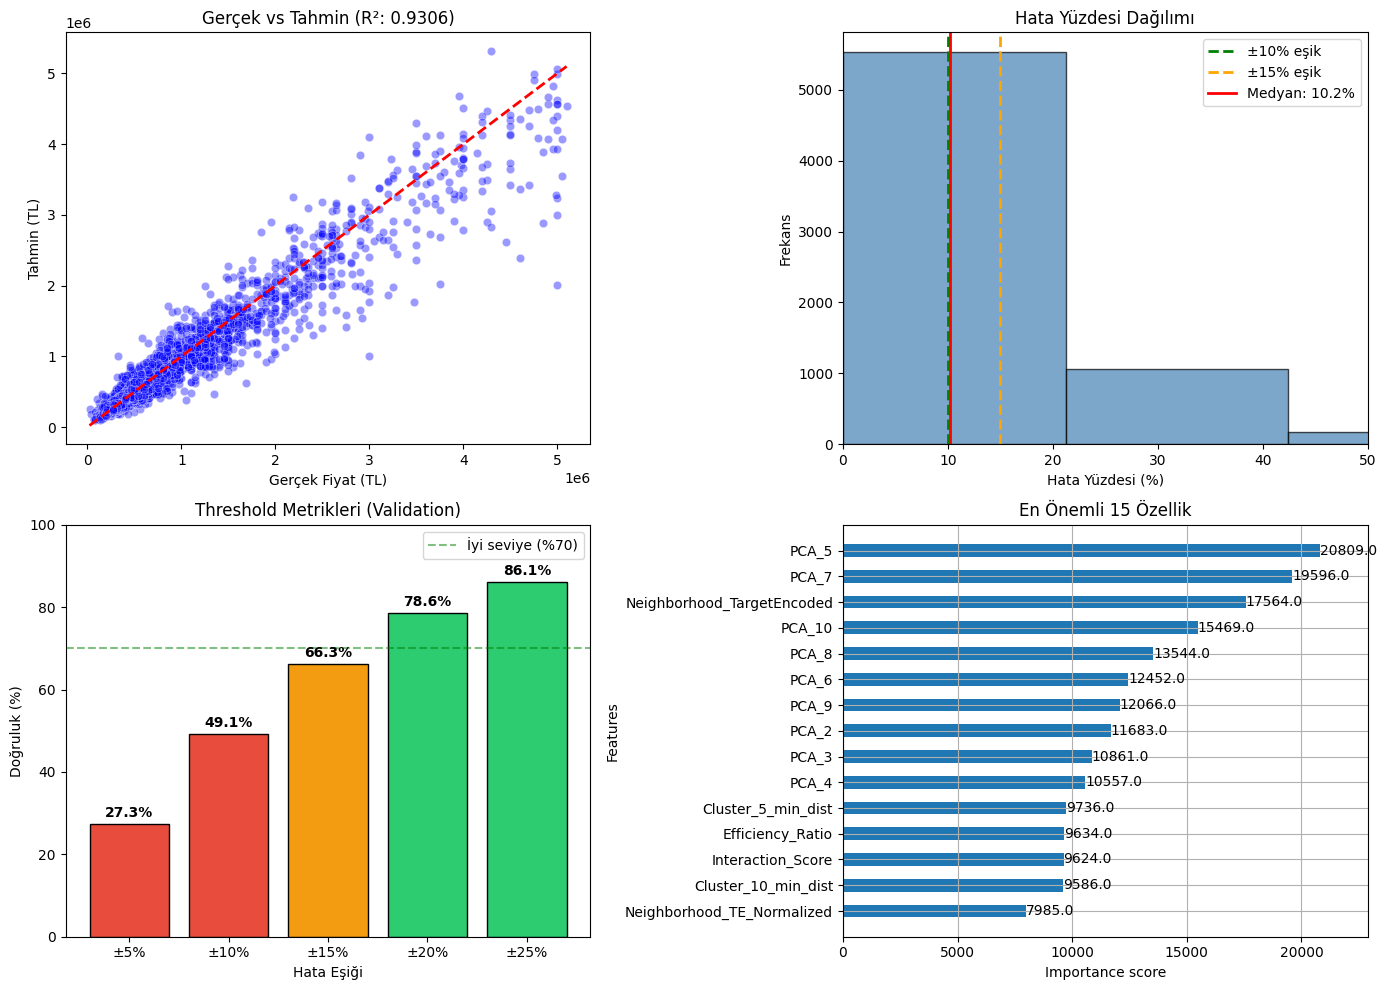

In [20]:
# Threshold Metrik Fonksiyonu
def calculate_threshold_accuracy(y_true, y_pred, thresholds=[5, 10, 15, 20, 25]):
    """
    Belirli hata eşiklerinin altında kalan tahminlerin yüzdesini hesaplar.
    Örn: %10 threshold = gerçek değerin ±%10 aralığındaki tahminlerin oranı
    """
    results = {}
    errors = np.abs((y_true - y_pred) / y_true) * 100  # Yüzdelik hata
    
    for thresh in thresholds:
        accuracy = (errors <= thresh).mean() * 100
        results[f'±{thresh}%'] = accuracy
    
    return results, errors

# Validation Seti Tahminleri
y_val_pred_log = model_xgb.predict(X_val)
y_val_pred_actual = np.expm1(y_val_pred_log)
y_val_actual = np.expm1(y_val)

# Validation Metrikleri
val_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_actual))
val_mae = mean_absolute_error(y_val_actual, y_val_pred_actual)
val_r2 = r2_score(y_val_actual, y_val_pred_actual)
val_thresholds, val_errors = calculate_threshold_accuracy(y_val_actual, y_val_pred_actual)

# Medyan ve Ortalama Hata Yüzdesi
median_error_pct = np.median(val_errors)
mean_error_pct = np.mean(val_errors)

print("=" * 70)
print("📊 XGBOOST MODEL RAPORU - VALIDATION SONUÇLARI")
print("=" * 70)

print("\n📈 TEMEL METRİKLER:")
print("-" * 50)
print(f"R-Kare (Açıklama Gücü) : %{val_r2 * 100:.2f}")
print(f"RMSE (Kök Ort. Kare H.): {val_rmse:,.0f} TL")
print(f"MAE (Ort. Mutlak Hata) : {val_mae:,.0f} TL")
print(f"Medyan Hata Yüzdesi    : %{median_error_pct:.2f}")
print(f"Ortalama Hata Yüzdesi  : %{mean_error_pct:.2f}")

print("\n" + "=" * 70)
print("🎯 THRESHOLD METRİKLERİ VE YORUMLARI")
print("=" * 70)
print("""
📌 THRESHOLD METRİĞİ NEDİR?
   • Tahminlerin gerçek fiyata ne kadar yakın olduğunu gösterir
   • Örnek: ±%10 = %85 demek: Tahminlerin %85'i gerçek fiyatın 
     ±%10'u içinde (1M TL ev için 900K-1.1M TL arası)

📌 YORUMLAMA REHBERİ:
   • ±%5  : Çok hassas tahmin (Profesyonel değerleme seviyesi)
   • ±%10 : İyi tahmin (Güvenilir fiyat tahmini)
   • ±%15 : Kabul edilebilir (Genel piyasa tahmini)
   • ±%20 : Orta seviye (Kaba fiyat tahmini)
   • ±%25 : Geniş aralık (Yaklaşık fiyat fikri)
""")

print("-" * 50)
print("📊 MODEL PERFORMANSI:")
print("-" * 50)

for thresh, acc in val_thresholds.items():
    # Yorum ekle
    if '5%' in thresh:
        if acc >= 50: quality = "🟢 Mükemmel"
        elif acc >= 30: quality = "🟡 İyi"
        else: quality = "🔴 Geliştirilmeli"
        desc = "Profesyonel değerleme"
    elif '10%' in thresh:
        if acc >= 70: quality = "🟢 Mükemmel"
        elif acc >= 50: quality = "🟡 İyi"
        else: quality = "🔴 Geliştirilmeli"
        desc = "Güvenilir tahmin"
    elif '15%' in thresh:
        if acc >= 80: quality = "🟢 Mükemmel"
        elif acc >= 65: quality = "🟡 İyi"
        else: quality = "🔴 Geliştirilmeli"
        desc = "Kabul edilebilir"
    elif '20%' in thresh:
        if acc >= 90: quality = "🟢 Mükemmel"
        elif acc >= 75: quality = "🟡 İyi"
        else: quality = "🔴 Geliştirilmeli"
        desc = "Kaba tahmin"
    else:  # 25%
        if acc >= 95: quality = "🟢 Mükemmel"
        elif acc >= 85: quality = "🟡 İyi"
        else: quality = "🔴 Geliştirilmeli"
        desc = "Yaklaşık fikir"
    
    print(f"   {thresh}: %{acc:.1f} → {quality} ({desc})")

print("\n" + "-" * 50)
print("📋 ÖRNEK YORUM:")
print("-" * 50)
t10 = val_thresholds['±10%']
t15 = val_thresholds['±15%']
print(f"""
   Gerçek fiyatı 2,000,000 TL olan bir ev için:
   
   • ±%10 aralığı: 1,800,000 - 2,200,000 TL
     Tahminlerin %{t10:.0f}'i bu aralıkta
   
   • ±%15 aralığı: 1,700,000 - 2,300,000 TL
     Tahminlerin %{t15:.0f}'i bu aralıkta
""")

print(f"Toplam Özellik: {X_train.shape[1]}")
print("=" * 70)

# Grafikler
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Gerçek vs Tahmin
ax1 = axes[0, 0]
sns.scatterplot(x=y_val_actual, y=y_val_pred_actual, alpha=0.4, color='blue', ax=ax1)
ax1.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2)
ax1.set_title(f"Gerçek vs Tahmin (R²: {val_r2:.4f})")
ax1.set_xlabel("Gerçek Fiyat (TL)")
ax1.set_ylabel("Tahmin (TL)")

# 2. Hata Dağılımı Histogramı
ax2 = axes[0, 1]
ax2.hist(val_errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=10, color='green', linestyle='--', linewidth=2, label='±10% eşik')
ax2.axvline(x=15, color='orange', linestyle='--', linewidth=2, label='±15% eşik')
ax2.axvline(x=median_error_pct, color='red', linestyle='-', linewidth=2, label=f'Medyan: {median_error_pct:.1f}%')
ax2.set_title("Hata Yüzdesi Dağılımı")
ax2.set_xlabel("Hata Yüzdesi (%)")
ax2.set_ylabel("Frekans")
ax2.legend()
ax2.set_xlim(0, 50)

# 3. Threshold Bar Grafiği
ax3 = axes[1, 0]
thresholds_list = list(val_thresholds.keys())
val_values = list(val_thresholds.values())
colors = ['#2ecc71' if v >= 70 else '#f39c12' if v >= 50 else '#e74c3c' for v in val_values]
bars = ax3.bar(thresholds_list, val_values, color=colors, edgecolor='black')
ax3.set_xlabel('Hata Eşiği')
ax3.set_ylabel('Doğruluk (%)')
ax3.set_title('Threshold Metrikleri (Validation)')
ax3.set_ylim(0, 100)
ax3.axhline(y=70, color='green', linestyle='--', alpha=0.5, label='İyi seviye (%70)')
ax3.legend()
for bar, val in zip(bars, val_values):
    ax3.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')

# 4. Önemli Özellikler
ax4 = axes[1, 1]
xgb.plot_importance(model_xgb, max_num_features=15, ax=ax4, height=0.5, title="En Önemli 15 Özellik")

plt.tight_layout()
plt.show()

In [21]:
# ==========================================
# OVERFITTING KONTROLÜ (Eğitim Sonrası)
# ==========================================

print("🔍 OVERFİTTİNG KONTROLÜ (Train vs Validation)")
print("=" * 60)

# Train seti tahminleri
y_train_pred_log = model_xgb.predict(X_train)
y_train_pred_actual = np.expm1(y_train_pred_log)
y_train_actual = np.expm1(y_train)

train_r2 = r2_score(y_train_actual, y_train_pred_actual)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))

# Validation metrikleri
val_r2_check = r2_score(y_val_actual, y_val_pred_actual)
val_rmse_check = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_actual))

print(f"\n📊 PERFORMANS KARŞILAŞTIRMASI:")
print("-" * 40)
print(f"   Train R²     : {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"   Validation R²: {val_r2_check:.4f} ({val_r2_check*100:.2f}%)")
print(f"   Fark         : {(train_r2 - val_r2_check):.4f} ({(train_r2 - val_r2_check)*100:.2f}%)")

print(f"\n   Train RMSE     : {train_rmse:,.0f} TL")
print(f"   Validation RMSE: {val_rmse_check:,.0f} TL")
print(f"   Fark           : {abs(train_rmse - val_rmse_check):,.0f} TL")

# Performans farkı analizi
r2_diff = train_r2 - val_r2_check
print("\n" + "-" * 40)
print("📋 DEĞERLENDİRME:")
print("-" * 40)

if r2_diff > 0.10:
    print(f"   🔴 CİDDİ OVERFİTTİNG: Train-Val farkı %{r2_diff*100:.1f}")
    print("   → Model eğitim verisini ezberliyor!")
    print("   → Regularization artırılmalı veya özellik sayısı azaltılmalı.")
elif r2_diff > 0.05:
    print(f"   🟡 HAFIF OVERFİTTİNG: Train-Val farkı %{r2_diff*100:.1f}")
    print("   → Kabul edilebilir seviyede, ancak dikkat edilmeli.")
    print("   → Regularization hafifçe artırılabilir.")
elif r2_diff > 0.02:
    print(f"   🟢 NORMAL: Train-Val farkı %{r2_diff*100:.1f}")
    print("   → Sağlıklı bir genelleme yapılıyor.")
else:
    print(f"   ✅ MÜKEMMEL: Train-Val farkı sadece %{r2_diff*100:.1f}")
    print("   → Model çok iyi genelleme yapıyor.")

print("\n" + "=" * 60)

🔍 OVERFİTTİNG KONTROLÜ (Train vs Validation)

📊 PERFORMANS KARŞILAŞTIRMASI:
----------------------------------------
   Train R²     : 0.9887 (98.87%)
   Validation R²: 0.9306 (93.06%)
   Fark         : 0.0581 (5.81%)

   Train RMSE     : 68,711 TL
   Validation RMSE: 178,560 TL
   Fark           : 109,849 TL

----------------------------------------
📋 DEĞERLENDİRME:
----------------------------------------
   🟡 HAFIF OVERFİTTİNG: Train-Val farkı %5.8
   → Kabul edilebilir seviyede, ancak dikkat edilmeli.
   → Regularization hafifçe artırılabilir.



In [23]:
# ============================================================
# 🚀 R² ARTTIRMA STRATEJİLERİ ANALİZİ
# ============================================================

print("=" * 70)
print("🔍 MODEL İYİLEŞTİRME ANALİZİ")
print("=" * 70)

# 1. Mevcut modelin erken durma noktası
print(f"\n📌 1. EARLY STOPPING ANALİZİ:")
print(f"   Model durduğu iterasyon: {model_xgb.best_iteration}")
print(f"   Ayarlanan maksimum: 10,000")
if model_xgb.best_iteration < 3000:
    print("   ⚠️  Model erken durdu - 15K'ya çıkarmak FAYDASIZ")
    print("   💡 Öneri: Regularization'ı azalt, learning_rate'i düşür")
else:
    print("   ✅ Model geç durdu - daha fazla epoch faydalı olabilir")

# 2. Yüksek hatalı örnekleri analiz et
print(f"\n📌 2. YÜKSEK HATALI ÖRNEKLER ANALİZİ:")
val_errors_pct = np.abs((y_val_actual - y_val_pred_actual) / y_val_actual) * 100
high_error_mask = val_errors_pct > 30  # %30'dan fazla hata

print(f"   Toplam validation örneği: {len(y_val_actual):,}")
print(f"   %30+ hatalı örnek sayısı: {high_error_mask.sum():,} ({high_error_mask.mean()*100:.1f}%)")

# Yüksek hatalı örneklerin fiyat dağılımı
high_error_prices = y_val_actual[high_error_mask]
print(f"\n   Yüksek hatalı evlerin fiyat aralığı:")
print(f"   • Min: {high_error_prices.min():,.0f} TL")
print(f"   • Max: {high_error_prices.max():,.0f} TL")
print(f"   • Medyan: {high_error_prices.median():,.0f} TL")

# 3. Fiyat segmentlerine göre performans
print(f"\n📌 3. FİYAT SEGMENTİ ANALİZİ:")
segments = [
    (0, 500000, "Düşük (0-500K)"),
    (500000, 1000000, "Orta-Alt (500K-1M)"),
    (1000000, 2000000, "Orta (1M-2M)"),
    (2000000, 5000000, "Yüksek (2M-5M)"),
    (5000000, float('inf'), "Lüks (5M+)")
]

for low, high, name in segments:
    mask = (y_val_actual >= low) & (y_val_actual < high)
    if mask.sum() > 0:
        seg_r2 = r2_score(y_val_actual[mask], y_val_pred_actual[mask])
        seg_count = mask.sum()
        seg_pct = mask.mean() * 100
        
        if seg_r2 >= 0.90:
            status = "🟢"
        elif seg_r2 >= 0.80:
            status = "🟡"
        else:
            status = "🔴"
        
        print(f"   {status} {name}: R²={seg_r2:.2%} ({seg_count:,} örnek, %{seg_pct:.1f})")

# 4. Öneriler
print("\n" + "=" * 70)
print("💡 R² ARTTIRMA ÖNERİLERİ (Öncelik Sırasına Göre)")
print("=" * 70)

print("""
🥇 1. REGULARIZATION AZALT (En Etkili)
   Mevcut reg_alpha/lambda çok yüksek olabilir
   → reg_alpha: 1-10 aralığına düşür
   → reg_lambda: 1-10 aralığına düşür

🥈 2. LEARNING RATE DÜŞÜR + EPOCH ARTTIR
   → learning_rate: 0.01-0.03 aralığı
   → n_estimators: 15000-20000
   → early_stopping_rounds: 100 (daha sabırlı)

🥉 3. AĞAÇ DERİNLİĞİNİ ARTTIR
   → max_depth: 8-12 aralığı (mevcut 4-8'den yükselt)
   → min_child_weight: 3-10 aralığı (mevcut 5-30'dan düşür)

4️⃣ OPTUNA TRİAL SAYISI
   → 100-150 trial yeterli (300 gereksiz uzun)
   → Arama aralıklarını daralt, trial'ı artırma

5️⃣ ÖZELLİK MÜHENDİSLİĞİ
   → PCA bileşenleri çok dominant görünüyor
   → Orijinal özellikleri de kullan
   → Polynomial özellikler ekle
""")

print("=" * 70)

🔍 MODEL İYİLEŞTİRME ANALİZİ

📌 1. EARLY STOPPING ANALİZİ:
   Model durduğu iterasyon: 19996
   Ayarlanan maksimum: 10,000
   ✅ Model geç durdu - daha fazla epoch faydalı olabilir

📌 2. YÜKSEK HATALI ÖRNEKLER ANALİZİ:
   Toplam validation örneği: 6,846
   %30+ hatalı örnek sayısı: 627 (9.2%)

   Yüksek hatalı evlerin fiyat aralığı:
   • Min: 22,222 TL
   • Max: 5,000,000 TL
   • Medyan: 395,000 TL

📌 3. FİYAT SEGMENTİ ANALİZİ:
   🔴 Düşük (0-500K): R²=63.88% (4,411 örnek, %64.4)
   🔴 Orta-Alt (500K-1M): R²=10.94% (1,590 örnek, %23.2)
   🔴 Orta (1M-2M): R²=-31.19% (502 örnek, %7.3)
   🔴 Yüksek (2M-5M): R²=50.30% (340 örnek, %5.0)
   🔴 Lüks (5M+): R²=-197585.20% (3 örnek, %0.0)

💡 R² ARTTIRMA ÖNERİLERİ (Öncelik Sırasına Göre)

🥇 1. REGULARIZATION AZALT (En Etkili)
   Mevcut reg_alpha/lambda çok yüksek olabilir
   → reg_alpha: 1-10 aralığına düşür
   → reg_lambda: 1-10 aralığına düşür

🥈 2. LEARNING RATE DÜŞÜR + EPOCH ARTTIR
   → learning_rate: 0.01-0.03 aralığı
   → n_estimators: 15000-200

In [ ]:
# ============================================================
# 💾 MODEL KAYDETME
# ============================================================
import joblib
import json
from datetime import datetime

# Model dosya adı (tarih ve R² ile)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_filename = f"sunumdaKullan/xgboost_model_r2_{val_r2*100:.0f}pct_{timestamp}.joblib"

# 1. Modeli kaydet (joblib - en hızlı ve güvenilir)
joblib.dump(model_xgb, model_filename)
print(f"✅ Model kaydedildi: {model_filename}")

# 2. Model metadata'sını kaydet
metadata = {
    "model_type": "XGBoost Regressor",
    "dataset": "hackathon_ultra_optimized.csv",
    "created_at": datetime.now().isoformat(),
    "metrics": {
        "r2_score": float(val_r2),
        "rmse": float(val_rmse),
        "mae": float(val_mae),
        "median_error_pct": float(median_error_pct),
        "mean_error_pct": float(mean_error_pct)
    },
    "threshold_metrics": {k: float(v) for k, v in val_thresholds.items()},
    "parameters": best_params,
    "training_info": {
        "n_features": X_train.shape[1],
        "n_train_samples": X_train.shape[0],
        "n_val_samples": X_val.shape[0],
        "best_iteration": model_xgb.best_iteration
    },
    "feature_columns": list(X.columns)
}

metadata_filename = model_filename.replace(".joblib", "_metadata.json")
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print(f"✅ Metadata kaydedildi: {metadata_filename}")

# 3. Ayrıca XGBoost native format olarak da kaydet (daha taşınabilir)
native_filename = model_filename.replace(".joblib", ".json")
model_xgb.save_model(native_filename)
print(f"✅ XGBoost native format: {native_filename}")

print("\n" + "=" * 60)
print("📦 KAYDEDILEN DOSYALAR:")
print("=" * 60)
print(f"""
   1. {model_filename}
      → Python'da yüklemek için: model = joblib.load('{model_filename}')
   
   2. {metadata_filename}
      → Model bilgileri, metrikler ve özellik listesi
   
   3. {native_filename}
      → XGBoost native format (diğer dillerde de kullanılabilir)
      → Yüklemek için: model.load_model('{native_filename}')
""")
print("=" * 60)

# Özet
print(f"\n🏆 MODEL PERFORMANS ÖZETİ:")
print(f"   R² Score: %{val_r2*100:.2f}")
print(f"   RMSE: {val_rmse:,.0f} TL")
print(f"   MAE: {val_mae:,.0f} TL")

✅ Model kaydedildi: xgboost_model_r2_93pct_20251214_0602.joblib
✅ Metadata kaydedildi: xgboost_model_r2_93pct_20251214_0602_metadata.json
✅ XGBoost native format: xgboost_model_r2_93pct_20251214_0602.json

📦 KAYDEDILEN DOSYALAR:

   1. xgboost_model_r2_93pct_20251214_0602.joblib
      → Python'da yüklemek için: model = joblib.load('xgboost_model_r2_93pct_20251214_0602.joblib')
   
   2. xgboost_model_r2_93pct_20251214_0602_metadata.json
      → Model bilgileri, metrikler ve özellik listesi
   
   3. xgboost_model_r2_93pct_20251214_0602.json
      → XGBoost native format (diğer dillerde de kullanılabilir)
      → Yüklemek için: model.load_model('xgboost_model_r2_93pct_20251214_0602.json')


🏆 MODEL PERFORMANS ÖZETİ:
   R² Score: %93.06
   RMSE: 178,560 TL
   MAE: 86,400 TL


🔄 K-FOLD CROSS-VALIDATION TESTİ
📌 Ayarlar:
   • Fold sayısı: 5
   • Toplam örnek: 27,381
   • Her fold eğitim: ~21,904 örnek
   • Her fold test: ~5,476 örnek
   Fold 1/5: R²=0.9263 | RMSE=185,794 TL | ±10%=49.3% | 193.1s
   Fold 2/5: R²=0.9437 | RMSE=158,910 TL | ±10%=49.6% | 160.2s
   Fold 3/5: R²=0.9322 | RMSE=162,618 TL | ±10%=48.5% | 178.1s
   Fold 4/5: R²=0.9205 | RMSE=184,178 TL | ±10%=49.8% | 110.3s
   Fold 5/5: R²=0.9353 | RMSE=161,903 TL | ±10%=49.6% | 110.2s

📊 CROSS-VALIDATION SONUÇLARI

🎯 GENEL PERFORMANS (Tüm Veri):
--------------------------------------------------
   R² Score      : 0.9316 (93.16%)
   RMSE          : 171,086 TL
   MAE           : 83,391 TL

📈 FOLD ORTALAMALARI (±Std):
--------------------------------------------------
   R² Score      : 0.9316 ± 0.0079
   RMSE          : 170,681 ± 11,758 TL
   ±10% Threshold: 49.4% ± 0.4%
   ±15% Threshold: 67.1% ± 0.5%

📉 MİN/MAX DEĞERLERİ:
--------------------------------------------------
   R² Min: 0.9205 | R² Max: 0

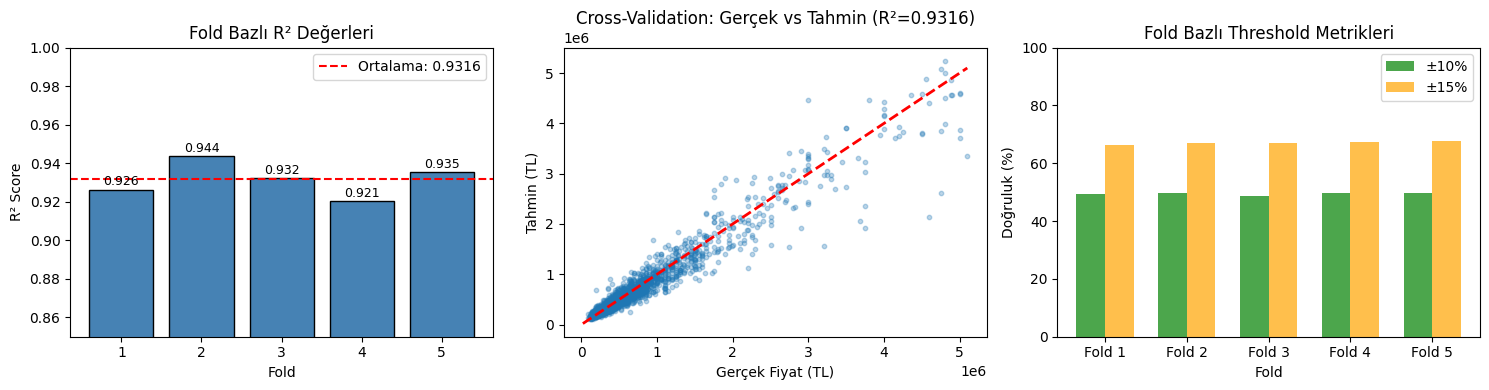

In [25]:
# ============================================================
# 🔄 CROSS-VALIDATION TESTİ
# ============================================================
from sklearn.model_selection import KFold, cross_val_predict
from xgboost import XGBRegressor
import time

print("🔄 K-FOLD CROSS-VALIDATION TESTİ")
print("=" * 70)

# Cross-validation ayarları
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# En iyi parametrelerle model oluştur
cv_model = XGBRegressor(
    n_estimators=20000,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    tree_method='hist',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=100
)

print(f"📌 Ayarlar:")
print(f"   • Fold sayısı: {n_folds}")
print(f"   • Toplam örnek: {len(X):,}")
print(f"   • Her fold eğitim: ~{len(X) * (n_folds-1) // n_folds:,} örnek")
print(f"   • Her fold test: ~{len(X) // n_folds:,} örnek")
print("=" * 70)

# Her fold için sonuçları sakla
fold_results = []
all_predictions = np.zeros(len(X))
start_time = time.time()

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    fold_start = time.time()
    
    # Veriyi böl
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Modeli eğit
    cv_model.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    
    # Tahmin yap
    y_fold_pred_log = cv_model.predict(X_fold_val)
    all_predictions[val_idx] = y_fold_pred_log
    
    # Gerçek fiyata dönüştür
    y_fold_pred_actual = np.expm1(y_fold_pred_log)
    y_fold_val_actual = np.expm1(y_fold_val)
    
    # Metrikleri hesapla
    fold_r2 = r2_score(y_fold_val_actual, y_fold_pred_actual)
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val_actual, y_fold_pred_actual))
    fold_mae = mean_absolute_error(y_fold_val_actual, y_fold_pred_actual)
    
    # Threshold metrikleri
    fold_errors = np.abs((y_fold_val_actual - y_fold_pred_actual) / y_fold_val_actual) * 100
    fold_t10 = (fold_errors <= 10).mean() * 100
    fold_t15 = (fold_errors <= 15).mean() * 100
    
    fold_time = time.time() - fold_start
    
    fold_results.append({
        'fold': fold_idx,
        'r2': fold_r2,
        'rmse': fold_rmse,
        'mae': fold_mae,
        't10': fold_t10,
        't15': fold_t15,
        'best_iter': cv_model.best_iteration,
        'time': fold_time
    })
    
    print(f"   Fold {fold_idx}/{n_folds}: R²={fold_r2:.4f} | RMSE={fold_rmse:,.0f} TL | ±10%={fold_t10:.1f}% | {fold_time:.1f}s")

total_time = time.time() - start_time

# Genel sonuçları hesapla
y_actual_all = np.expm1(y)
y_pred_all = np.expm1(all_predictions)

overall_r2 = r2_score(y_actual_all, y_pred_all)
overall_rmse = np.sqrt(mean_squared_error(y_actual_all, y_pred_all))
overall_mae = mean_absolute_error(y_actual_all, y_pred_all)

# Ortalama ve standart sapma
r2_scores = [f['r2'] for f in fold_results]
rmse_scores = [f['rmse'] for f in fold_results]
t10_scores = [f['t10'] for f in fold_results]
t15_scores = [f['t15'] for f in fold_results]

print("\n" + "=" * 70)
print("📊 CROSS-VALIDATION SONUÇLARI")
print("=" * 70)

print(f"\n🎯 GENEL PERFORMANS (Tüm Veri):")
print("-" * 50)
print(f"   R² Score      : {overall_r2:.4f} ({overall_r2*100:.2f}%)")
print(f"   RMSE          : {overall_rmse:,.0f} TL")
print(f"   MAE           : {overall_mae:,.0f} TL")

print(f"\n📈 FOLD ORTALAMALARI (±Std):")
print("-" * 50)
print(f"   R² Score      : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"   RMSE          : {np.mean(rmse_scores):,.0f} ± {np.std(rmse_scores):,.0f} TL")
print(f"   ±10% Threshold: {np.mean(t10_scores):.1f}% ± {np.std(t10_scores):.1f}%")
print(f"   ±15% Threshold: {np.mean(t15_scores):.1f}% ± {np.std(t15_scores):.1f}%")

print(f"\n📉 MİN/MAX DEĞERLERİ:")
print("-" * 50)
print(f"   R² Min: {min(r2_scores):.4f} | R² Max: {max(r2_scores):.4f}")
print(f"   RMSE Min: {min(rmse_scores):,.0f} TL | RMSE Max: {max(rmse_scores):,.0f} TL")

# Tutarlılık değerlendirmesi
r2_cv = np.std(r2_scores) / np.mean(r2_scores) * 100  # Coefficient of Variation
print(f"\n📋 TUTARLILIK DEĞERLENDİRMESİ:")
print("-" * 50)
if r2_cv < 2:
    print(f"   ✅ MÜKEMMEL: R² değişkenliği çok düşük (CV={r2_cv:.2f}%)")
    print("   → Model tüm fold'larda tutarlı performans gösteriyor.")
elif r2_cv < 5:
    print(f"   🟢 İYİ: R² değişkenliği düşük (CV={r2_cv:.2f}%)")
    print("   → Model genel olarak tutarlı.")
elif r2_cv < 10:
    print(f"   🟡 KABUL EDİLEBİLİR: R² değişkenliği orta (CV={r2_cv:.2f}%)")
    print("   → Bazı veri segmentlerinde performans farklılığı var.")
else:
    print(f"   🔴 DİKKAT: R² değişkenliği yüksek (CV={r2_cv:.2f}%)")
    print("   → Model bazı veri alt kümelerinde tutarsız.")

print(f"\n⏱️ Toplam süre: {total_time:.1f} saniye")
print("=" * 70)

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Fold bazlı R² değerleri
ax1 = axes[0]
folds = [f['fold'] for f in fold_results]
r2_vals = [f['r2'] for f in fold_results]
bars = ax1.bar(folds, r2_vals, color='steelblue', edgecolor='black')
ax1.axhline(y=np.mean(r2_vals), color='red', linestyle='--', label=f'Ortalama: {np.mean(r2_vals):.4f}')
ax1.set_xlabel('Fold')
ax1.set_ylabel('R² Score')
ax1.set_title('Fold Bazlı R² Değerleri')
ax1.set_ylim(0.85, 1.0)
ax1.legend()
for bar, val in zip(bars, r2_vals):
    ax1.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# 2. CV Gerçek vs Tahmin
ax2 = axes[1]
sample_idx = np.random.choice(len(y_actual_all), min(3000, len(y_actual_all)), replace=False)
ax2.scatter(y_actual_all.iloc[sample_idx], y_pred_all[sample_idx], alpha=0.3, s=10)
ax2.plot([y_actual_all.min(), y_actual_all.max()], [y_actual_all.min(), y_actual_all.max()], 'r--', lw=2)
ax2.set_xlabel('Gerçek Fiyat (TL)')
ax2.set_ylabel('Tahmin (TL)')
ax2.set_title(f'Cross-Validation: Gerçek vs Tahmin (R²={overall_r2:.4f})')

# 3. Threshold karşılaştırma
ax3 = axes[2]
x_pos = np.arange(n_folds)
width = 0.35
ax3.bar(x_pos - width/2, t10_scores, width, label='±10%', color='green', alpha=0.7)
ax3.bar(x_pos + width/2, t15_scores, width, label='±15%', color='orange', alpha=0.7)
ax3.set_xlabel('Fold')
ax3.set_ylabel('Doğruluk (%)')
ax3.set_title('Fold Bazlı Threshold Metrikleri')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Fold {i+1}' for i in range(n_folds)])
ax3.legend()
ax3.set_ylim(0, 100)

plt.tight_layout()
plt.show()